Assignment Steps

1. Design and Train a GAN on MNIST dataset so that Generator G can create random fake digit images.

2. Save G.pkl and D.pkl

3. Use the Generator G to create a dataset of 100 fake digits images (S1)

4. Save the latent samples and fake images to a Folder "Fake_Digits"

5. Train a CNN Classifier to classify the images

*   Take 100 random samples from real dataset (S0)
*   Save the classifier trained as C.pkl
*   Obtain Classification error for S0 and S1.
*   While using S1 - (Use torchvision.Datasets.ImageFolder)

# Step 1 - Design and Train a GAN

Import necessary Libraries

In [1]:
!pip install torchinfo

In [2]:
!sudo pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [3]:
import torch
print("Pytorch version", torch.__version__)
from torch import nn, optim
from torch.utils.data import DataLoader, Subset

import torchvision
print("Torchvision version", torchvision.__version__)
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchinfo import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import zipfile

from sklearn.metrics import confusion_matrix
import itertools

import os
from torchvision.utils import save_image

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

from torch.autograd import Variable

from torchviz import make_dot

from torch.nn import functional as F

Pytorch version 2.3.0+cu121
Torchvision version 0.18.0+cu121


Define the Device

In [4]:
print("GPU Name:", torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU Name: Tesla T4 

Device is: cuda 

Total number of GPUs: 1


Load the MNIST Dataset

In [5]:
# Since the data is loaded via PyTorch less transformations are required.

# * ToTensor(): Converts a PIL Image or numpy.ndarray to a tensor. This operation scales the image pixel values from the range [0, 255] to [0.0, 1.0].

# * Normalize(mean, std): Normalizes the tensor image with mean and standard deviation.

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,) , std=(0.5,))])

In [6]:
# Load the training dataset using datasets module from torchvision

mnist_dataset_training = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16033714.86it/s]


Extracting ./data_src/MNIST/raw/train-images-idx3-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 534499.21it/s]


Extracting ./data_src/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4490106.74it/s]


Extracting ./data_src/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10496159.10it/s]

Extracting ./data_src/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



In [7]:
# Load the testing dataset using datasets module from torchvision

mnist_dataset_testing = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

In [8]:
print('Length of the MNIST (training) dataset:', len(mnist_dataset_training))

Length of the MNIST (training) dataset: 60000


In [9]:
print('Length of the MNIST (Testing) dataset:', len(mnist_dataset_testing))

Length of the MNIST (Testing) dataset: 10000


In [10]:
print('Shape of the MNIST (training) dataset:', mnist_dataset_training.data.shape)

Shape of the MNIST (training) dataset: torch.Size([60000, 28, 28])


In [11]:
print('Shape of the MNIST (testing) dataset:', mnist_dataset_testing.data.shape)

Shape of the MNIST (testing) dataset: torch.Size([10000, 28, 28])


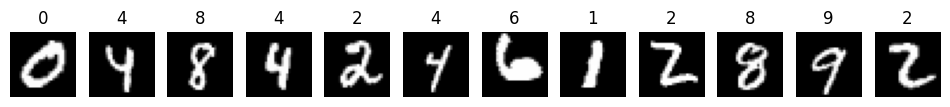

In [ ]:
# Display 12 randomly selected samples from the MNIST (training) dataset

fig, axis = plt.subplots(nrows=1, ncols=12, figsize=(12,3))

for ax, _ in zip(axis.ravel(), range(12)):
  inx = np.random.randint(len(mnist_dataset_training))
  ax.imshow(mnist_dataset_training.data[inx], cmap='gray')
  ax.set_title(int(mnist_dataset_training.targets[inx]), fontsize = 12)
  ax.axis(False)

Define Data Loader

In [12]:
#  DataLoader in PyTorch provides a convenient and efficient way to iterate over a dataset.
# drop_last = True is done to discard the last incomplete batch if the dataset size is not
# divisible by the batch size to keep the handling simple

loaders = {
    'train' : torch.utils.data.DataLoader(mnist_dataset_training,
                                          batch_size=128,
                                          shuffle=True,
                                          drop_last=True),

    'test'  : torch.utils.data.DataLoader(mnist_dataset_testing,
                                          batch_size=128,
                                          shuffle=True,
                                          drop_last=True)
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f8f27181f60>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f8f27181ff0>}

In [13]:
print('Length of the dataloader (training):', len(loaders['train']))

Length of the dataloader (training): 468


In [14]:
print('Length of the dataloader (testing):', len(loaders['test']))

Length of the dataloader (testing): 78


# Trained a Simple GAN Architecture

Create Discriminator Architecture

In [15]:
# The discriminator is a classifier trained using supervised learning. It classifies whether an image is real (1) or not (0).
# The discriminator is trained using both MNIST images and generated fake images.
# A fully connected neural network with non linearity applied through LeakyReLU
# Sigmoid activation layer is used to depict the probability of input image to be fake / real

class DISCRIMINATOR(nn.Module):
  def __init__(self):
    super(DISCRIMINATOR, self).__init__()

    self.discriminator = nn.Sequential()
    self.discriminator.add_module('linr1', nn.Linear(in_features=28*28, out_features=1024))
    self.discriminator.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
    self.discriminator.add_module('drop1', nn.Dropout(p=0.3))

    self.discriminator.add_module('linr2', nn.Linear(in_features=1024, out_features=512))
    self.discriminator.add_module('lrel2', nn.LeakyReLU(negative_slope=0.2))
    self.discriminator.add_module('drop2', nn.Dropout(p=0.3))

    self.discriminator.add_module('linr3', nn.Linear(in_features=512, out_features=256))
    self.discriminator.add_module('lrel3', nn.LeakyReLU(negative_slope=0.2))
    self.discriminator.add_module('drop3', nn.Dropout(p=0.3))

    self.discriminator.add_module('linr4', nn.Linear(in_features=256, out_features=1))
    self.discriminator.add_module('sigmd4', nn.Sigmoid())

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.discriminator(x)
    return x

Visualize Discriminator Architecture

In [16]:
summary(DISCRIMINATOR(), input_size= (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DISCRIMINATOR                            [128, 1]                  --
├─Sequential: 1-1                        [128, 1]                  --
│    └─Linear: 2-1                       [128, 1024]               803,840
│    └─LeakyReLU: 2-2                    [128, 1024]               --
│    └─Dropout: 2-3                      [128, 1024]               --
│    └─Linear: 2-4                       [128, 512]                524,800
│    └─LeakyReLU: 2-5                    [128, 512]                --
│    └─Dropout: 2-6                      [128, 512]                --
│    └─Linear: 2-7                       [128, 256]                131,328
│    └─LeakyReLU: 2-8                    [128, 256]                --
│    └─Dropout: 2-9                      [128, 256]                --
│    └─Linear: 2-10                      [128, 1]                  257
│    └─Sigmoid: 2-11                     [128, 1]                  --

Create Generator Architecture

In [17]:
# The generator is used to create fake images with random latent samples as inputs.
# A fully connected network which also uses LeakyReLU to incorporate non linearity.
# TanH function is used as an activation function to maintain stability of the model by scaling the output to the range [-1,1]

class GENERATOR(nn.Module):
  def __init__(self):
    super(GENERATOR, self).__init__()

    self.generator = nn.Sequential()
    self.generator.add_module('linr1', nn.Linear(in_features=100, out_features=256))
    self.generator.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
    self.generator.add_module('linr2', nn.Linear(in_features=256, out_features=512))
    self.generator.add_module('lrel2', nn.LeakyReLU(negative_slope=0.2))
    self.generator.add_module('linr3', nn.Linear(in_features=512, out_features=1024))
    self.generator.add_module('lrel3', nn.LeakyReLU(negative_slope=0.2))
    self.generator.add_module('linr4', nn.Linear(in_features=1024, out_features=28*28))
    self.generator.add_module('tanh4', nn.Tanh())

  def forward(self, x):
    x = self.generator(x)
    return x

Visualize Generator Architecture

In [ ]:
summary(GENERATOR(), input_size=(128, 100))

Layer (type:depth-idx)                   Output Shape              Param #
GENERATOR                                [128, 784]                --
├─Sequential: 1-1                        [128, 784]                --
│    └─Linear: 2-1                       [128, 256]                25,856
│    └─LeakyReLU: 2-2                    [128, 256]                --
│    └─Linear: 2-3                       [128, 512]                131,584
│    └─LeakyReLU: 2-4                    [128, 512]                --
│    └─Linear: 2-5                       [128, 1024]               525,312
│    └─LeakyReLU: 2-6                    [128, 1024]               --
│    └─Linear: 2-7                       [128, 784]                803,600
│    └─Tanh: 2-8                         [128, 784]                --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 190.25
Input size (MB): 0.05
Forward/backward pass size (MB): 2.64
Params size (MB): 5.95
Estimated Total Siz

Instantiate models

In [18]:
discriminator = DISCRIMINATOR().to(device)
generator = GENERATOR().to(device)

Optimizers and loss function

In [19]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)
criterion = nn.BCELoss()

 Visualize the generator model

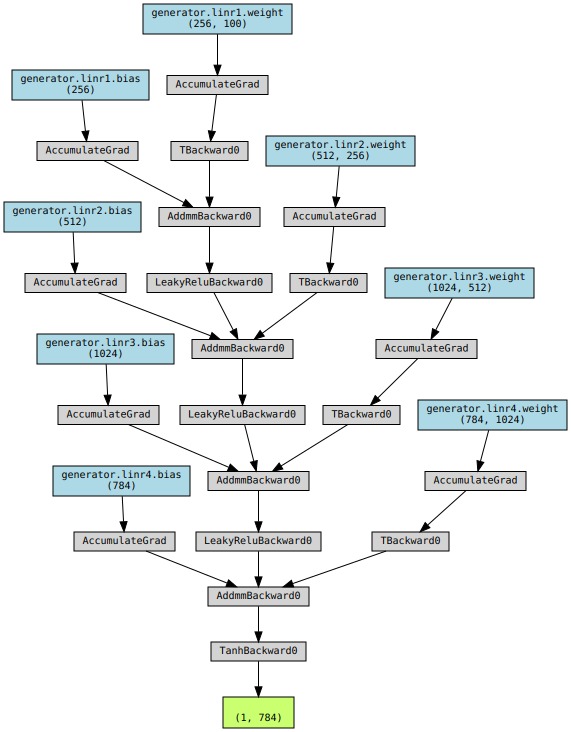

In [ ]:
# Using a single latent example for visualization, it is passed through the generator.
z = torch.randn(1, 100).to(device)

fake_img = generator(z)

make_dot(fake_img, params=dict(generator.named_parameters()))


Visualize the discriminator model

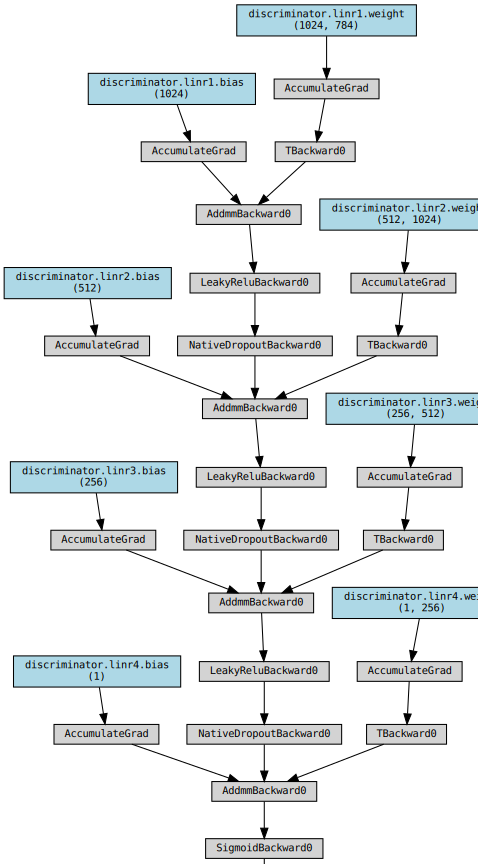

In [ ]:
# A random image generated, is passed through the discriminator.
random_img = torch.randn(1, 1, 28, 28).to(device)

output = discriminator(random_img)

make_dot(output, params=dict(discriminator.named_parameters()))


Visualize the combined GAN model

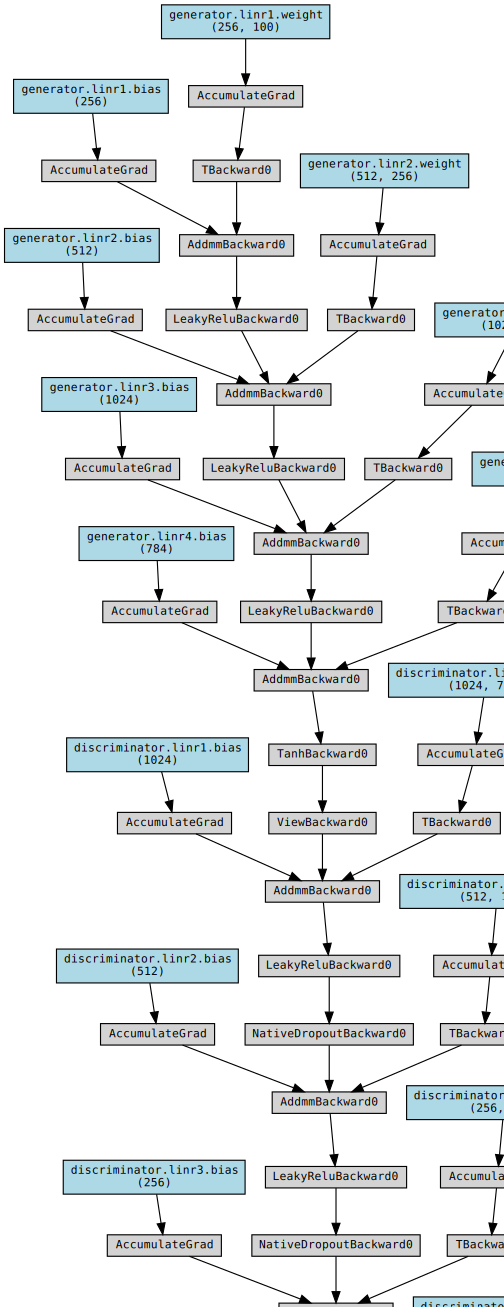

In [ ]:
# A random latent vector for demonstration purpose
z = torch.randn(1, 100).to(device)

# Forward pass through the generator
fake_img = generator(z)

# Forward pass through the discriminator with the generated image
output = discriminator(fake_img)

# Visualize the combined GAN model
make_dot(output, params={**dict(generator.named_parameters()), **dict(discriminator.named_parameters())})


Training function for discriminator

In [20]:
def discriminator_training_batch(real_samples, fake_samples, model, criterion, optimizer):
    model.train() # Activate training mode

    # Real samples
    preds_real = model(real_samples)
    error_real = criterion(preds_real, torch.ones(len(real_samples), 1).to(device))

    # Fake samples
    preds_fake = model(fake_samples)
    error_fake = criterion(preds_fake, torch.zeros(len(fake_samples), 1).to(device))

    # Calculate accuracy
    real_accuracy = (preds_real >= 0.5).float().mean().item()
    fake_accuracy = (preds_fake < 0.5).float().mean().item()
    accuracy = 0.5 * (real_accuracy + fake_accuracy)

    optimizer.zero_grad()
    error_real.backward()
    error_fake.backward()
    optimizer.step()
    return error_real + error_fake, accuracy

Training function for generator

In [21]:
def generator_training_batch(fake_samples, model, criterion, optimizer):
    preds = model(fake_samples)
    error = criterion(preds, torch.ones(len(fake_samples), 1).to(device))
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    return error

Train the GAN

Initially the model was trained for 100 epochs without adjusting learning rate or dropout layers in the network. - The results were not bad.

In [ ]:
n_epochs = 100
discriminator_loss, generator_loss = [], []

for epoch in range(n_epochs):
    discriminator_losses, generator_losses = [], []

    for data, _ in tqdm(loaders['train']):
        real_data = data.to(device)
        fake_data = generator(torch.randn(128, 100).to(device)).detach()
        discrim_batch_loss = discriminator_training_batch(real_samples=real_data, fake_samples=fake_data, model=discriminator, criterion=criterion, optimizer=d_optimizer)
        discriminator_losses.append(discrim_batch_loss.item())

        fake_data = generator(torch.randn(128, 100).to(device))
        gen_batch_loss = generator_training_batch(fake_samples=fake_data, model=discriminator, criterion=criterion, optimizer=g_optimizer)
        generator_losses.append(gen_batch_loss.item())

    discriminator_loss.append(np.mean(discriminator_losses))
    generator_loss.append(np.mean(generator_losses))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{n_epochs}\t| Discriminator loss: {np.mean(discriminator_losses):.4f} | Generator loss: {np.mean(generator_losses):.4f}')


100%|██████████| 468/468 [00:17<00:00, 26.50it/s]


Epoch: 10/100	| Discriminator loss: 0.3560 | Generator loss: 3.8628


100%|██████████| 468/468 [00:17<00:00, 26.52it/s]


Epoch: 20/100	| Discriminator loss: 0.6944 | Generator loss: 2.2074


100%|██████████| 468/468 [00:17<00:00, 26.59it/s]


Epoch: 30/100	| Discriminator loss: 0.9053 | Generator loss: 1.6667


100%|██████████| 468/468 [00:17<00:00, 26.91it/s]


Epoch: 40/100	| Discriminator loss: 1.0066 | Generator loss: 1.4333


100%|██████████| 468/468 [00:17<00:00, 26.79it/s]


Epoch: 50/100	| Discriminator loss: 1.0840 | Generator loss: 1.2312


100%|██████████| 468/468 [00:17<00:00, 26.95it/s]


Epoch: 60/100	| Discriminator loss: 1.1408 | Generator loss: 1.1307


100%|██████████| 468/468 [00:17<00:00, 27.23it/s]


Epoch: 70/100	| Discriminator loss: 1.1385 | Generator loss: 1.1314


100%|██████████| 468/468 [00:17<00:00, 26.80it/s]


Epoch: 80/100	| Discriminator loss: 1.1709 | Generator loss: 1.0709


100%|██████████| 468/468 [00:17<00:00, 26.42it/s]


Epoch: 90/100	| Discriminator loss: 1.2097 | Generator loss: 1.0200


100%|██████████| 468/468 [00:17<00:00, 26.74it/s]

Epoch: 100/100	| Discriminator loss: 1.2009 | Generator loss: 1.0105


Plot Losses - Below is the plot for a model trained for 100 epochs

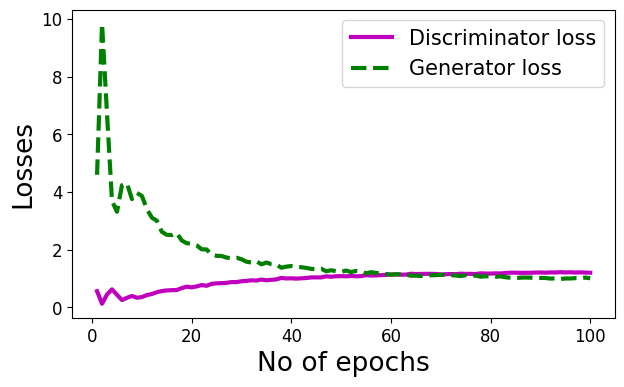

In [ ]:
N = np.arange(n_epochs) + 1
plt.figure(figsize=(7, 4))
plt.plot(N, discriminator_loss, 'm-', linewidth=3, label='Discriminator loss')
plt.plot(N, generator_loss, 'g--', linewidth=3, label='Generator loss')
plt.xlabel('No of epochs', fontsize=19)
plt.ylabel('Losses', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.show()

1. In order to improve the model further, the epochs of training were increased to 200.
2. Slight modifications were done to the learning rate. (The generator was given a lesser learning rate than discriminator) Through this the idea is to allow the generator to catch up and produce better samples over time.
3. Dropout can help regularize the discriminator if dropout rates are too high, it can make training unstable therefor it was also reduced.

These changes showed better results in the model trained.


In [22]:
n_epochs = 200
discriminator_loss, generator_loss = [], []
discriminator_accuracy = []

for epoch in range(n_epochs):
    discriminator_losses, generator_losses, accuracies = [], [], []

    for data, _ in tqdm(loaders['train']):
        real_data = data.to(device)
        fake_data = generator(torch.randn(128, 100).to(device)).detach()
        discrim_batch_loss, accuracy = discriminator_training_batch(real_samples=real_data, fake_samples=fake_data, model=discriminator, criterion=criterion, optimizer=d_optimizer)
        discriminator_losses.append(discrim_batch_loss.item())
        accuracies.append(accuracy)

        fake_data = generator(torch.randn(128, 100).to(device))
        gen_batch_loss = generator_training_batch(fake_samples=fake_data, model=discriminator, criterion=criterion, optimizer=g_optimizer)
        generator_losses.append(gen_batch_loss.item())

    discriminator_loss.append(np.mean(discriminator_losses))
    generator_loss.append(np.mean(generator_losses))
    discriminator_accuracy.append(np.mean(accuracies))

    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Discriminator loss: {np.mean(discriminator_losses):.4f} | Generator loss: {np.mean(generator_losses):.4f} | Discriminator accuracy: {np.mean(accuracies) * 100:.2f}%')


100%|██████████| 468/468 [00:18<00:00, 25.60it/s]


Epoch: 1/200	| Discriminator loss: 0.7221 | Generator loss: 3.7317 | Discriminator accuracy: 82.35%


100%|██████████| 468/468 [00:18<00:00, 25.98it/s]


Epoch: 2/200	| Discriminator loss: 0.9104 | Generator loss: 2.7431 | Discriminator accuracy: 79.58%


100%|██████████| 468/468 [00:18<00:00, 25.89it/s]


Epoch: 3/200	| Discriminator loss: 0.7407 | Generator loss: 2.3912 | Discriminator accuracy: 84.34%


100%|██████████| 468/468 [00:17<00:00, 27.48it/s]


Epoch: 4/200	| Discriminator loss: 0.2076 | Generator loss: 4.4982 | Discriminator accuracy: 96.71%


100%|██████████| 468/468 [00:19<00:00, 23.46it/s]


Epoch: 5/200	| Discriminator loss: 0.2466 | Generator loss: 4.9403 | Discriminator accuracy: 95.80%


100%|██████████| 468/468 [00:17<00:00, 26.06it/s]


Epoch: 6/200	| Discriminator loss: 0.1927 | Generator loss: 5.1547 | Discriminator accuracy: 96.80%


100%|██████████| 468/468 [00:17<00:00, 27.10it/s]


Epoch: 7/200	| Discriminator loss: 0.1876 | Generator loss: 5.1830 | Discriminator accuracy: 96.81%


100%|██████████| 468/468 [00:17<00:00, 26.11it/s]


Epoch: 8/200	| Discriminator loss: 0.2344 | Generator loss: 4.7960 | Discriminator accuracy: 95.84%


100%|██████████| 468/468 [00:17<00:00, 27.25it/s]


Epoch: 9/200	| Discriminator loss: 0.2428 | Generator loss: 4.5478 | Discriminator accuracy: 95.69%


100%|██████████| 468/468 [00:17<00:00, 26.12it/s]


Epoch: 10/200	| Discriminator loss: 0.1903 | Generator loss: 4.8491 | Discriminator accuracy: 96.72%


100%|██████████| 468/468 [00:17<00:00, 27.30it/s]


Epoch: 11/200	| Discriminator loss: 0.1919 | Generator loss: 5.1486 | Discriminator accuracy: 96.53%


100%|██████████| 468/468 [00:17<00:00, 27.39it/s]


Epoch: 12/200	| Discriminator loss: 0.2508 | Generator loss: 4.1350 | Discriminator accuracy: 95.45%


100%|██████████| 468/468 [00:17<00:00, 26.28it/s]


Epoch: 13/200	| Discriminator loss: 0.2475 | Generator loss: 4.1005 | Discriminator accuracy: 95.49%


100%|██████████| 468/468 [00:16<00:00, 27.60it/s]


Epoch: 14/200	| Discriminator loss: 0.2945 | Generator loss: 3.5621 | Discriminator accuracy: 94.58%


100%|██████████| 468/468 [00:18<00:00, 24.85it/s]


Epoch: 15/200	| Discriminator loss: 0.3295 | Generator loss: 3.3252 | Discriminator accuracy: 93.84%


100%|██████████| 468/468 [00:17<00:00, 27.19it/s]


Epoch: 16/200	| Discriminator loss: 0.3533 | Generator loss: 3.1257 | Discriminator accuracy: 93.38%


100%|██████████| 468/468 [00:17<00:00, 27.41it/s]


Epoch: 17/200	| Discriminator loss: 0.3755 | Generator loss: 2.8959 | Discriminator accuracy: 93.01%


100%|██████████| 468/468 [00:18<00:00, 25.84it/s]


Epoch: 18/200	| Discriminator loss: 0.3912 | Generator loss: 2.9967 | Discriminator accuracy: 92.58%


100%|██████████| 468/468 [00:16<00:00, 27.59it/s]


Epoch: 19/200	| Discriminator loss: 0.4386 | Generator loss: 2.7396 | Discriminator accuracy: 91.60%


100%|██████████| 468/468 [00:17<00:00, 27.09it/s]


Epoch: 20/200	| Discriminator loss: 0.4628 | Generator loss: 2.6157 | Discriminator accuracy: 90.95%


100%|██████████| 468/468 [00:18<00:00, 25.94it/s]


Epoch: 21/200	| Discriminator loss: 0.4316 | Generator loss: 2.7810 | Discriminator accuracy: 91.58%


100%|██████████| 468/468 [00:17<00:00, 27.37it/s]


Epoch: 22/200	| Discriminator loss: 0.4326 | Generator loss: 2.7307 | Discriminator accuracy: 91.65%


100%|██████████| 468/468 [00:17<00:00, 26.75it/s]


Epoch: 23/200	| Discriminator loss: 0.4532 | Generator loss: 2.7162 | Discriminator accuracy: 91.14%


100%|██████████| 468/468 [00:17<00:00, 26.67it/s]


Epoch: 24/200	| Discriminator loss: 0.4929 | Generator loss: 2.5734 | Discriminator accuracy: 90.16%


100%|██████████| 468/468 [00:17<00:00, 27.21it/s]


Epoch: 25/200	| Discriminator loss: 0.4764 | Generator loss: 2.6008 | Discriminator accuracy: 90.52%


100%|██████████| 468/468 [00:17<00:00, 26.32it/s]


Epoch: 26/200	| Discriminator loss: 0.4898 | Generator loss: 2.5736 | Discriminator accuracy: 90.19%


100%|██████████| 468/468 [00:18<00:00, 25.60it/s]


Epoch: 27/200	| Discriminator loss: 0.5149 | Generator loss: 2.4997 | Discriminator accuracy: 89.59%


100%|██████████| 468/468 [00:17<00:00, 27.12it/s]


Epoch: 28/200	| Discriminator loss: 0.5733 | Generator loss: 2.3482 | Discriminator accuracy: 88.08%


100%|██████████| 468/468 [00:17<00:00, 26.08it/s]


Epoch: 29/200	| Discriminator loss: 0.5815 | Generator loss: 2.2873 | Discriminator accuracy: 87.88%


100%|██████████| 468/468 [00:17<00:00, 27.32it/s]


Epoch: 30/200	| Discriminator loss: 0.6248 | Generator loss: 2.1645 | Discriminator accuracy: 86.81%


100%|██████████| 468/468 [00:17<00:00, 26.93it/s]


Epoch: 31/200	| Discriminator loss: 0.6112 | Generator loss: 2.2080 | Discriminator accuracy: 87.07%


100%|██████████| 468/468 [00:17<00:00, 26.78it/s]


Epoch: 32/200	| Discriminator loss: 0.6303 | Generator loss: 2.1951 | Discriminator accuracy: 86.52%


100%|██████████| 468/468 [00:16<00:00, 27.58it/s]


Epoch: 33/200	| Discriminator loss: 0.6283 | Generator loss: 2.1933 | Discriminator accuracy: 86.44%


100%|██████████| 468/468 [00:17<00:00, 26.09it/s]


Epoch: 34/200	| Discriminator loss: 0.6257 | Generator loss: 2.1745 | Discriminator accuracy: 86.64%


100%|██████████| 468/468 [00:16<00:00, 27.60it/s]


Epoch: 35/200	| Discriminator loss: 0.6691 | Generator loss: 2.1140 | Discriminator accuracy: 85.48%


100%|██████████| 468/468 [00:17<00:00, 27.34it/s]


Epoch: 36/200	| Discriminator loss: 0.6567 | Generator loss: 2.1782 | Discriminator accuracy: 85.71%


100%|██████████| 468/468 [00:18<00:00, 25.97it/s]


Epoch: 37/200	| Discriminator loss: 0.6550 | Generator loss: 2.0979 | Discriminator accuracy: 85.84%


100%|██████████| 468/468 [00:17<00:00, 27.41it/s]


Epoch: 38/200	| Discriminator loss: 0.6576 | Generator loss: 2.0977 | Discriminator accuracy: 85.63%


100%|██████████| 468/468 [00:17<00:00, 26.40it/s]


Epoch: 39/200	| Discriminator loss: 0.6862 | Generator loss: 2.0575 | Discriminator accuracy: 85.09%


100%|██████████| 468/468 [00:18<00:00, 25.10it/s]


Epoch: 40/200	| Discriminator loss: 0.6950 | Generator loss: 2.0294 | Discriminator accuracy: 84.76%


100%|██████████| 468/468 [00:17<00:00, 27.31it/s]


Epoch: 41/200	| Discriminator loss: 0.7131 | Generator loss: 1.9503 | Discriminator accuracy: 84.08%


100%|██████████| 468/468 [00:17<00:00, 26.48it/s]


Epoch: 42/200	| Discriminator loss: 0.7454 | Generator loss: 1.9030 | Discriminator accuracy: 83.20%


100%|██████████| 468/468 [00:17<00:00, 27.45it/s]


Epoch: 43/200	| Discriminator loss: 0.7579 | Generator loss: 1.8805 | Discriminator accuracy: 82.88%


100%|██████████| 468/468 [00:17<00:00, 27.18it/s]


Epoch: 44/200	| Discriminator loss: 0.7729 | Generator loss: 1.8418 | Discriminator accuracy: 82.44%


100%|██████████| 468/468 [00:17<00:00, 26.61it/s]


Epoch: 45/200	| Discriminator loss: 0.7784 | Generator loss: 1.8275 | Discriminator accuracy: 82.28%


100%|██████████| 468/468 [00:17<00:00, 27.47it/s]


Epoch: 46/200	| Discriminator loss: 0.7891 | Generator loss: 1.7883 | Discriminator accuracy: 81.98%


100%|██████████| 468/468 [00:17<00:00, 26.33it/s]


Epoch: 47/200	| Discriminator loss: 0.7995 | Generator loss: 1.7716 | Discriminator accuracy: 81.64%


100%|██████████| 468/468 [00:17<00:00, 27.52it/s]


Epoch: 48/200	| Discriminator loss: 0.7987 | Generator loss: 1.8025 | Discriminator accuracy: 81.54%


100%|██████████| 468/468 [00:17<00:00, 27.43it/s]


Epoch: 49/200	| Discriminator loss: 0.8183 | Generator loss: 1.7254 | Discriminator accuracy: 81.15%


100%|██████████| 468/468 [00:17<00:00, 26.48it/s]


Epoch: 50/200	| Discriminator loss: 0.8164 | Generator loss: 1.7533 | Discriminator accuracy: 81.22%


100%|██████████| 468/468 [00:17<00:00, 27.25it/s]


Epoch: 51/200	| Discriminator loss: 0.8117 | Generator loss: 1.7264 | Discriminator accuracy: 81.32%


100%|██████████| 468/468 [00:17<00:00, 27.52it/s]


Epoch: 52/200	| Discriminator loss: 0.8324 | Generator loss: 1.6718 | Discriminator accuracy: 80.69%


100%|██████████| 468/468 [00:19<00:00, 24.37it/s]


Epoch: 53/200	| Discriminator loss: 0.8285 | Generator loss: 1.7342 | Discriminator accuracy: 80.74%


100%|██████████| 468/468 [00:17<00:00, 27.39it/s]


Epoch: 54/200	| Discriminator loss: 0.8286 | Generator loss: 1.7267 | Discriminator accuracy: 80.65%


100%|██████████| 468/468 [00:17<00:00, 26.90it/s]


Epoch: 55/200	| Discriminator loss: 0.8498 | Generator loss: 1.6647 | Discriminator accuracy: 80.11%


100%|██████████| 468/468 [00:17<00:00, 26.35it/s]


Epoch: 56/200	| Discriminator loss: 0.8475 | Generator loss: 1.6798 | Discriminator accuracy: 80.23%


100%|██████████| 468/468 [00:17<00:00, 27.41it/s]


Epoch: 57/200	| Discriminator loss: 0.8612 | Generator loss: 1.6703 | Discriminator accuracy: 79.86%


100%|██████████| 468/468 [00:18<00:00, 25.80it/s]


Epoch: 58/200	| Discriminator loss: 0.8607 | Generator loss: 1.6351 | Discriminator accuracy: 79.83%


100%|██████████| 468/468 [00:17<00:00, 27.45it/s]


Epoch: 59/200	| Discriminator loss: 0.8660 | Generator loss: 1.6645 | Discriminator accuracy: 79.71%


100%|██████████| 468/468 [00:17<00:00, 27.51it/s]


Epoch: 60/200	| Discriminator loss: 0.8793 | Generator loss: 1.6042 | Discriminator accuracy: 79.19%


100%|██████████| 468/468 [00:17<00:00, 26.42it/s]


Epoch: 61/200	| Discriminator loss: 0.8860 | Generator loss: 1.6147 | Discriminator accuracy: 78.98%


100%|██████████| 468/468 [00:17<00:00, 27.25it/s]


Epoch: 62/200	| Discriminator loss: 0.8963 | Generator loss: 1.5685 | Discriminator accuracy: 78.65%


100%|██████████| 468/468 [00:17<00:00, 27.27it/s]


Epoch: 63/200	| Discriminator loss: 0.8927 | Generator loss: 1.5827 | Discriminator accuracy: 78.79%


100%|██████████| 468/468 [00:17<00:00, 26.52it/s]


Epoch: 64/200	| Discriminator loss: 0.8879 | Generator loss: 1.5820 | Discriminator accuracy: 78.90%


100%|██████████| 468/468 [00:18<00:00, 25.92it/s]


Epoch: 65/200	| Discriminator loss: 0.9131 | Generator loss: 1.5708 | Discriminator accuracy: 78.11%


100%|██████████| 468/468 [00:17<00:00, 26.36it/s]


Epoch: 66/200	| Discriminator loss: 0.9269 | Generator loss: 1.5457 | Discriminator accuracy: 77.50%


100%|██████████| 468/468 [00:16<00:00, 27.80it/s]


Epoch: 67/200	| Discriminator loss: 0.9096 | Generator loss: 1.5456 | Discriminator accuracy: 78.21%


100%|██████████| 468/468 [00:16<00:00, 27.69it/s]


Epoch: 68/200	| Discriminator loss: 0.9306 | Generator loss: 1.5221 | Discriminator accuracy: 77.49%


100%|██████████| 468/468 [00:17<00:00, 26.03it/s]


Epoch: 69/200	| Discriminator loss: 0.9385 | Generator loss: 1.4973 | Discriminator accuracy: 77.37%


100%|██████████| 468/468 [00:17<00:00, 27.49it/s]


Epoch: 70/200	| Discriminator loss: 0.9409 | Generator loss: 1.4810 | Discriminator accuracy: 77.14%


100%|██████████| 468/468 [00:16<00:00, 27.66it/s]


Epoch: 71/200	| Discriminator loss: 0.9393 | Generator loss: 1.4919 | Discriminator accuracy: 77.12%


100%|██████████| 468/468 [00:17<00:00, 26.42it/s]


Epoch: 72/200	| Discriminator loss: 0.9490 | Generator loss: 1.4819 | Discriminator accuracy: 76.71%


100%|██████████| 468/468 [00:17<00:00, 27.28it/s]


Epoch: 73/200	| Discriminator loss: 0.9570 | Generator loss: 1.4505 | Discriminator accuracy: 76.67%


100%|██████████| 468/468 [00:17<00:00, 26.82it/s]


Epoch: 74/200	| Discriminator loss: 0.9644 | Generator loss: 1.4530 | Discriminator accuracy: 76.48%


100%|██████████| 468/468 [00:17<00:00, 26.86it/s]


Epoch: 75/200	| Discriminator loss: 0.9641 | Generator loss: 1.4314 | Discriminator accuracy: 76.32%


100%|██████████| 468/468 [00:17<00:00, 27.12it/s]


Epoch: 76/200	| Discriminator loss: 0.9676 | Generator loss: 1.4308 | Discriminator accuracy: 76.18%


100%|██████████| 468/468 [00:17<00:00, 26.21it/s]


Epoch: 77/200	| Discriminator loss: 0.9754 | Generator loss: 1.4239 | Discriminator accuracy: 75.95%


100%|██████████| 468/468 [00:17<00:00, 26.58it/s]


Epoch: 78/200	| Discriminator loss: 0.9819 | Generator loss: 1.4063 | Discriminator accuracy: 75.66%


100%|██████████| 468/468 [00:16<00:00, 27.60it/s]


Epoch: 79/200	| Discriminator loss: 0.9793 | Generator loss: 1.4221 | Discriminator accuracy: 75.85%


100%|██████████| 468/468 [00:17<00:00, 26.35it/s]


Epoch: 80/200	| Discriminator loss: 0.9902 | Generator loss: 1.3810 | Discriminator accuracy: 75.52%


100%|██████████| 468/468 [00:16<00:00, 27.56it/s]


Epoch: 81/200	| Discriminator loss: 1.0058 | Generator loss: 1.3591 | Discriminator accuracy: 74.99%


100%|██████████| 468/468 [00:17<00:00, 27.24it/s]


Epoch: 82/200	| Discriminator loss: 0.9960 | Generator loss: 1.3935 | Discriminator accuracy: 75.35%


100%|██████████| 468/468 [00:17<00:00, 27.17it/s]


Epoch: 83/200	| Discriminator loss: 1.0083 | Generator loss: 1.3670 | Discriminator accuracy: 74.86%


100%|██████████| 468/468 [00:16<00:00, 27.88it/s]


Epoch: 84/200	| Discriminator loss: 1.0154 | Generator loss: 1.3534 | Discriminator accuracy: 74.60%


100%|██████████| 468/468 [00:17<00:00, 26.85it/s]


Epoch: 85/200	| Discriminator loss: 1.0087 | Generator loss: 1.3564 | Discriminator accuracy: 74.80%


100%|██████████| 468/468 [00:16<00:00, 27.63it/s]


Epoch: 86/200	| Discriminator loss: 1.0151 | Generator loss: 1.3639 | Discriminator accuracy: 74.68%


100%|██████████| 468/468 [00:16<00:00, 27.89it/s]


Epoch: 87/200	| Discriminator loss: 1.0306 | Generator loss: 1.3115 | Discriminator accuracy: 73.98%


100%|██████████| 468/468 [00:17<00:00, 26.60it/s]


Epoch: 88/200	| Discriminator loss: 1.0223 | Generator loss: 1.3454 | Discriminator accuracy: 74.34%


100%|██████████| 468/468 [00:16<00:00, 27.97it/s]


Epoch: 89/200	| Discriminator loss: 1.0246 | Generator loss: 1.3287 | Discriminator accuracy: 74.20%


100%|██████████| 468/468 [00:16<00:00, 27.62it/s]


Epoch: 90/200	| Discriminator loss: 1.0374 | Generator loss: 1.2963 | Discriminator accuracy: 73.72%


100%|██████████| 468/468 [00:17<00:00, 26.41it/s]


Epoch: 91/200	| Discriminator loss: 1.0385 | Generator loss: 1.3068 | Discriminator accuracy: 73.72%


100%|██████████| 468/468 [00:17<00:00, 26.52it/s]


Epoch: 92/200	| Discriminator loss: 1.0490 | Generator loss: 1.2830 | Discriminator accuracy: 73.41%


100%|██████████| 468/468 [00:17<00:00, 26.80it/s]


Epoch: 93/200	| Discriminator loss: 1.0553 | Generator loss: 1.2458 | Discriminator accuracy: 73.12%


100%|██████████| 468/468 [00:17<00:00, 26.36it/s]


Epoch: 94/200	| Discriminator loss: 1.0454 | Generator loss: 1.3072 | Discriminator accuracy: 73.39%


100%|██████████| 468/468 [00:16<00:00, 27.73it/s]


Epoch: 95/200	| Discriminator loss: 1.0498 | Generator loss: 1.2796 | Discriminator accuracy: 73.26%


100%|██████████| 468/468 [00:17<00:00, 26.96it/s]


Epoch: 96/200	| Discriminator loss: 1.0610 | Generator loss: 1.2653 | Discriminator accuracy: 72.92%


100%|██████████| 468/468 [00:17<00:00, 27.44it/s]


Epoch: 97/200	| Discriminator loss: 1.0736 | Generator loss: 1.2610 | Discriminator accuracy: 72.28%


100%|██████████| 468/468 [00:16<00:00, 28.16it/s]


Epoch: 98/200	| Discriminator loss: 1.0711 | Generator loss: 1.2432 | Discriminator accuracy: 72.62%


100%|██████████| 468/468 [00:17<00:00, 26.69it/s]


Epoch: 99/200	| Discriminator loss: 1.0815 | Generator loss: 1.2236 | Discriminator accuracy: 72.17%


100%|██████████| 468/468 [00:16<00:00, 27.89it/s]


Epoch: 100/200	| Discriminator loss: 1.0698 | Generator loss: 1.2486 | Discriminator accuracy: 72.65%


100%|██████████| 468/468 [00:16<00:00, 27.79it/s]


Epoch: 101/200	| Discriminator loss: 1.0806 | Generator loss: 1.2459 | Discriminator accuracy: 72.17%


100%|██████████| 468/468 [00:17<00:00, 26.45it/s]


Epoch: 102/200	| Discriminator loss: 1.0772 | Generator loss: 1.2321 | Discriminator accuracy: 72.37%


100%|██████████| 468/468 [00:16<00:00, 27.95it/s]


Epoch: 103/200	| Discriminator loss: 1.0936 | Generator loss: 1.2110 | Discriminator accuracy: 71.67%


100%|██████████| 468/468 [00:16<00:00, 27.53it/s]


Epoch: 104/200	| Discriminator loss: 1.0842 | Generator loss: 1.2178 | Discriminator accuracy: 71.97%


100%|██████████| 468/468 [00:18<00:00, 25.13it/s]


Epoch: 105/200	| Discriminator loss: 1.0963 | Generator loss: 1.2234 | Discriminator accuracy: 71.50%


100%|██████████| 468/468 [00:16<00:00, 27.86it/s]


Epoch: 106/200	| Discriminator loss: 1.0961 | Generator loss: 1.1989 | Discriminator accuracy: 71.51%


100%|██████████| 468/468 [00:17<00:00, 27.06it/s]


Epoch: 107/200	| Discriminator loss: 1.1104 | Generator loss: 1.1921 | Discriminator accuracy: 70.96%


100%|██████████| 468/468 [00:17<00:00, 27.38it/s]


Epoch: 108/200	| Discriminator loss: 1.1069 | Generator loss: 1.1938 | Discriminator accuracy: 71.11%


100%|██████████| 468/468 [00:17<00:00, 27.25it/s]


Epoch: 109/200	| Discriminator loss: 1.1025 | Generator loss: 1.1820 | Discriminator accuracy: 71.31%


100%|██████████| 468/468 [00:17<00:00, 26.74it/s]


Epoch: 110/200	| Discriminator loss: 1.1116 | Generator loss: 1.1697 | Discriminator accuracy: 70.83%


100%|██████████| 468/468 [00:16<00:00, 27.81it/s]


Epoch: 111/200	| Discriminator loss: 1.1140 | Generator loss: 1.1734 | Discriminator accuracy: 70.80%


100%|██████████| 468/468 [00:17<00:00, 27.45it/s]


Epoch: 112/200	| Discriminator loss: 1.1155 | Generator loss: 1.1638 | Discriminator accuracy: 70.72%


100%|██████████| 468/468 [00:17<00:00, 26.55it/s]


Epoch: 113/200	| Discriminator loss: 1.1151 | Generator loss: 1.1674 | Discriminator accuracy: 70.60%


100%|██████████| 468/468 [00:16<00:00, 27.53it/s]


Epoch: 114/200	| Discriminator loss: 1.1230 | Generator loss: 1.1510 | Discriminator accuracy: 70.16%


100%|██████████| 468/468 [00:16<00:00, 27.67it/s]


Epoch: 115/200	| Discriminator loss: 1.1266 | Generator loss: 1.1564 | Discriminator accuracy: 70.45%


100%|██████████| 468/468 [00:17<00:00, 26.41it/s]


Epoch: 116/200	| Discriminator loss: 1.1208 | Generator loss: 1.1662 | Discriminator accuracy: 70.66%


100%|██████████| 468/468 [00:16<00:00, 27.78it/s]


Epoch: 117/200	| Discriminator loss: 1.1238 | Generator loss: 1.1587 | Discriminator accuracy: 70.41%


100%|██████████| 468/468 [00:18<00:00, 25.31it/s]


Epoch: 118/200	| Discriminator loss: 1.1286 | Generator loss: 1.1692 | Discriminator accuracy: 70.45%


100%|██████████| 468/468 [00:17<00:00, 27.20it/s]


Epoch: 119/200	| Discriminator loss: 1.1349 | Generator loss: 1.1496 | Discriminator accuracy: 69.85%


100%|██████████| 468/468 [00:16<00:00, 27.56it/s]


Epoch: 120/200	| Discriminator loss: 1.1351 | Generator loss: 1.1455 | Discriminator accuracy: 70.02%


100%|██████████| 468/468 [00:17<00:00, 26.22it/s]


Epoch: 121/200	| Discriminator loss: 1.1259 | Generator loss: 1.1400 | Discriminator accuracy: 70.43%


100%|██████████| 468/468 [00:17<00:00, 27.49it/s]


Epoch: 122/200	| Discriminator loss: 1.1344 | Generator loss: 1.1386 | Discriminator accuracy: 69.92%


100%|██████████| 468/468 [00:16<00:00, 27.54it/s]


Epoch: 123/200	| Discriminator loss: 1.1403 | Generator loss: 1.1492 | Discriminator accuracy: 69.73%


100%|██████████| 468/468 [00:17<00:00, 26.28it/s]


Epoch: 124/200	| Discriminator loss: 1.1340 | Generator loss: 1.1419 | Discriminator accuracy: 69.95%


100%|██████████| 468/468 [00:17<00:00, 27.38it/s]


Epoch: 125/200	| Discriminator loss: 1.1314 | Generator loss: 1.1505 | Discriminator accuracy: 70.14%


100%|██████████| 468/468 [00:16<00:00, 27.62it/s]


Epoch: 126/200	| Discriminator loss: 1.1439 | Generator loss: 1.1199 | Discriminator accuracy: 69.53%


100%|██████████| 468/468 [00:18<00:00, 25.91it/s]


Epoch: 127/200	| Discriminator loss: 1.1447 | Generator loss: 1.1275 | Discriminator accuracy: 69.46%


100%|██████████| 468/468 [00:16<00:00, 27.84it/s]


Epoch: 128/200	| Discriminator loss: 1.1378 | Generator loss: 1.1336 | Discriminator accuracy: 69.72%


100%|██████████| 468/468 [00:17<00:00, 26.99it/s]


Epoch: 129/200	| Discriminator loss: 1.1367 | Generator loss: 1.1216 | Discriminator accuracy: 69.69%


100%|██████████| 468/468 [00:17<00:00, 26.61it/s]


Epoch: 130/200	| Discriminator loss: 1.1465 | Generator loss: 1.1247 | Discriminator accuracy: 69.43%


100%|██████████| 468/468 [00:16<00:00, 27.99it/s]


Epoch: 131/200	| Discriminator loss: 1.1406 | Generator loss: 1.1208 | Discriminator accuracy: 69.96%


100%|██████████| 468/468 [00:19<00:00, 24.54it/s]


Epoch: 132/200	| Discriminator loss: 1.1454 | Generator loss: 1.1339 | Discriminator accuracy: 69.49%


100%|██████████| 468/468 [00:16<00:00, 28.39it/s]


Epoch: 133/200	| Discriminator loss: 1.1463 | Generator loss: 1.1098 | Discriminator accuracy: 69.51%


100%|██████████| 468/468 [00:16<00:00, 28.25it/s]


Epoch: 134/200	| Discriminator loss: 1.1413 | Generator loss: 1.1316 | Discriminator accuracy: 69.68%


100%|██████████| 468/468 [00:17<00:00, 27.18it/s]


Epoch: 135/200	| Discriminator loss: 1.1468 | Generator loss: 1.1189 | Discriminator accuracy: 69.49%


100%|██████████| 468/468 [00:16<00:00, 27.69it/s]


Epoch: 136/200	| Discriminator loss: 1.1531 | Generator loss: 1.1137 | Discriminator accuracy: 69.21%


100%|██████████| 468/468 [00:16<00:00, 28.15it/s]


Epoch: 137/200	| Discriminator loss: 1.1544 | Generator loss: 1.1002 | Discriminator accuracy: 68.98%


100%|██████████| 468/468 [00:17<00:00, 26.84it/s]


Epoch: 138/200	| Discriminator loss: 1.1539 | Generator loss: 1.0977 | Discriminator accuracy: 69.16%


100%|██████████| 468/468 [00:16<00:00, 28.12it/s]


Epoch: 139/200	| Discriminator loss: 1.1557 | Generator loss: 1.1025 | Discriminator accuracy: 69.01%


100%|██████████| 468/468 [00:16<00:00, 28.08it/s]


Epoch: 140/200	| Discriminator loss: 1.1551 | Generator loss: 1.0957 | Discriminator accuracy: 68.83%


100%|██████████| 468/468 [00:17<00:00, 26.58it/s]


Epoch: 141/200	| Discriminator loss: 1.1489 | Generator loss: 1.0930 | Discriminator accuracy: 69.39%


100%|██████████| 468/468 [00:16<00:00, 28.18it/s]


Epoch: 142/200	| Discriminator loss: 1.1608 | Generator loss: 1.1064 | Discriminator accuracy: 68.75%


100%|██████████| 468/468 [00:16<00:00, 27.57it/s]


Epoch: 143/200	| Discriminator loss: 1.1501 | Generator loss: 1.1085 | Discriminator accuracy: 69.30%


100%|██████████| 468/468 [00:17<00:00, 26.85it/s]


Epoch: 144/200	| Discriminator loss: 1.1627 | Generator loss: 1.0941 | Discriminator accuracy: 68.85%


100%|██████████| 468/468 [00:16<00:00, 27.58it/s]


Epoch: 145/200	| Discriminator loss: 1.1592 | Generator loss: 1.0944 | Discriminator accuracy: 68.93%


100%|██████████| 468/468 [00:17<00:00, 26.44it/s]


Epoch: 146/200	| Discriminator loss: 1.1530 | Generator loss: 1.1055 | Discriminator accuracy: 69.19%


100%|██████████| 468/468 [00:17<00:00, 26.69it/s]


Epoch: 147/200	| Discriminator loss: 1.1584 | Generator loss: 1.0993 | Discriminator accuracy: 68.92%


100%|██████████| 468/468 [00:16<00:00, 27.79it/s]


Epoch: 148/200	| Discriminator loss: 1.1622 | Generator loss: 1.0968 | Discriminator accuracy: 68.72%


100%|██████████| 468/468 [00:17<00:00, 27.25it/s]


Epoch: 149/200	| Discriminator loss: 1.1580 | Generator loss: 1.0937 | Discriminator accuracy: 68.75%


100%|██████████| 468/468 [00:17<00:00, 26.75it/s]


Epoch: 150/200	| Discriminator loss: 1.1683 | Generator loss: 1.0823 | Discriminator accuracy: 68.40%


100%|██████████| 468/468 [00:16<00:00, 27.92it/s]


Epoch: 151/200	| Discriminator loss: 1.1604 | Generator loss: 1.0895 | Discriminator accuracy: 68.72%


100%|██████████| 468/468 [00:17<00:00, 27.21it/s]


Epoch: 152/200	| Discriminator loss: 1.1613 | Generator loss: 1.0843 | Discriminator accuracy: 68.68%


100%|██████████| 468/468 [00:17<00:00, 27.32it/s]


Epoch: 153/200	| Discriminator loss: 1.1675 | Generator loss: 1.0860 | Discriminator accuracy: 68.64%


100%|██████████| 468/468 [00:16<00:00, 27.87it/s]


Epoch: 154/200	| Discriminator loss: 1.1688 | Generator loss: 1.0766 | Discriminator accuracy: 68.47%


100%|██████████| 468/468 [00:17<00:00, 27.14it/s]


Epoch: 155/200	| Discriminator loss: 1.1647 | Generator loss: 1.0893 | Discriminator accuracy: 68.64%


100%|██████████| 468/468 [00:16<00:00, 27.70it/s]


Epoch: 156/200	| Discriminator loss: 1.1716 | Generator loss: 1.0681 | Discriminator accuracy: 68.46%


100%|██████████| 468/468 [00:16<00:00, 27.74it/s]


Epoch: 157/200	| Discriminator loss: 1.1670 | Generator loss: 1.0710 | Discriminator accuracy: 68.64%


100%|██████████| 468/468 [00:17<00:00, 26.50it/s]


Epoch: 158/200	| Discriminator loss: 1.1666 | Generator loss: 1.0919 | Discriminator accuracy: 68.53%


100%|██████████| 468/468 [00:17<00:00, 26.70it/s]


Epoch: 159/200	| Discriminator loss: 1.1611 | Generator loss: 1.0901 | Discriminator accuracy: 68.74%


100%|██████████| 468/468 [00:16<00:00, 28.07it/s]


Epoch: 160/200	| Discriminator loss: 1.1657 | Generator loss: 1.0829 | Discriminator accuracy: 68.75%


100%|██████████| 468/468 [00:17<00:00, 26.99it/s]


Epoch: 161/200	| Discriminator loss: 1.1679 | Generator loss: 1.0680 | Discriminator accuracy: 68.58%


100%|██████████| 468/468 [00:16<00:00, 28.19it/s]


Epoch: 162/200	| Discriminator loss: 1.1731 | Generator loss: 1.0624 | Discriminator accuracy: 68.32%


100%|██████████| 468/468 [00:16<00:00, 28.39it/s]


Epoch: 163/200	| Discriminator loss: 1.1687 | Generator loss: 1.0686 | Discriminator accuracy: 68.41%


100%|██████████| 468/468 [00:17<00:00, 26.42it/s]


Epoch: 164/200	| Discriminator loss: 1.1728 | Generator loss: 1.0714 | Discriminator accuracy: 68.49%


100%|██████████| 468/468 [00:16<00:00, 28.21it/s]


Epoch: 165/200	| Discriminator loss: 1.1677 | Generator loss: 1.0789 | Discriminator accuracy: 68.61%


100%|██████████| 468/468 [00:17<00:00, 27.29it/s]


Epoch: 166/200	| Discriminator loss: 1.1722 | Generator loss: 1.0740 | Discriminator accuracy: 68.34%


100%|██████████| 468/468 [00:17<00:00, 26.24it/s]


Epoch: 167/200	| Discriminator loss: 1.1672 | Generator loss: 1.0753 | Discriminator accuracy: 68.51%


100%|██████████| 468/468 [00:16<00:00, 27.78it/s]


Epoch: 168/200	| Discriminator loss: 1.1721 | Generator loss: 1.0862 | Discriminator accuracy: 68.42%


100%|██████████| 468/468 [00:16<00:00, 27.73it/s]


Epoch: 169/200	| Discriminator loss: 1.1700 | Generator loss: 1.0597 | Discriminator accuracy: 68.53%


100%|██████████| 468/468 [00:17<00:00, 26.87it/s]


Epoch: 170/200	| Discriminator loss: 1.1793 | Generator loss: 1.0588 | Discriminator accuracy: 67.86%


100%|██████████| 468/468 [00:17<00:00, 27.50it/s]


Epoch: 171/200	| Discriminator loss: 1.1754 | Generator loss: 1.0538 | Discriminator accuracy: 68.14%


100%|██████████| 468/468 [00:17<00:00, 26.76it/s]


Epoch: 172/200	| Discriminator loss: 1.1817 | Generator loss: 1.0476 | Discriminator accuracy: 68.21%


100%|██████████| 468/468 [00:18<00:00, 25.53it/s]


Epoch: 173/200	| Discriminator loss: 1.1823 | Generator loss: 1.0665 | Discriminator accuracy: 67.91%


100%|██████████| 468/468 [00:16<00:00, 27.69it/s]


Epoch: 174/200	| Discriminator loss: 1.1764 | Generator loss: 1.0537 | Discriminator accuracy: 68.27%


100%|██████████| 468/468 [00:17<00:00, 26.43it/s]


Epoch: 175/200	| Discriminator loss: 1.1869 | Generator loss: 1.0390 | Discriminator accuracy: 67.60%


100%|██████████| 468/468 [00:16<00:00, 28.24it/s]


Epoch: 176/200	| Discriminator loss: 1.1763 | Generator loss: 1.0607 | Discriminator accuracy: 68.23%


100%|██████████| 468/468 [00:16<00:00, 28.01it/s]


Epoch: 177/200	| Discriminator loss: 1.1820 | Generator loss: 1.0318 | Discriminator accuracy: 67.87%


100%|██████████| 468/468 [00:17<00:00, 26.35it/s]


Epoch: 178/200	| Discriminator loss: 1.1820 | Generator loss: 1.0647 | Discriminator accuracy: 67.77%


100%|██████████| 468/468 [00:16<00:00, 27.93it/s]


Epoch: 179/200	| Discriminator loss: 1.1833 | Generator loss: 1.0456 | Discriminator accuracy: 67.77%


100%|██████████| 468/468 [00:16<00:00, 28.09it/s]


Epoch: 180/200	| Discriminator loss: 1.1835 | Generator loss: 1.0521 | Discriminator accuracy: 67.78%


100%|██████████| 468/468 [00:17<00:00, 26.99it/s]


Epoch: 181/200	| Discriminator loss: 1.1899 | Generator loss: 1.0384 | Discriminator accuracy: 67.74%


100%|██████████| 468/468 [00:17<00:00, 27.50it/s]


Epoch: 182/200	| Discriminator loss: 1.1844 | Generator loss: 1.0485 | Discriminator accuracy: 67.70%


100%|██████████| 468/468 [00:16<00:00, 28.18it/s]


Epoch: 183/200	| Discriminator loss: 1.1860 | Generator loss: 1.0448 | Discriminator accuracy: 67.74%


100%|██████████| 468/468 [00:17<00:00, 26.00it/s]


Epoch: 184/200	| Discriminator loss: 1.1861 | Generator loss: 1.0358 | Discriminator accuracy: 67.72%


100%|██████████| 468/468 [00:16<00:00, 27.98it/s]


Epoch: 185/200	| Discriminator loss: 1.1880 | Generator loss: 1.0295 | Discriminator accuracy: 67.61%


100%|██████████| 468/468 [00:16<00:00, 28.05it/s]


Epoch: 186/200	| Discriminator loss: 1.1909 | Generator loss: 1.0423 | Discriminator accuracy: 67.38%


100%|██████████| 468/468 [00:18<00:00, 25.42it/s]


Epoch: 187/200	| Discriminator loss: 1.1866 | Generator loss: 1.0522 | Discriminator accuracy: 67.74%


100%|██████████| 468/468 [00:16<00:00, 28.32it/s]


Epoch: 188/200	| Discriminator loss: 1.1792 | Generator loss: 1.0547 | Discriminator accuracy: 68.07%


100%|██████████| 468/468 [00:17<00:00, 26.95it/s]


Epoch: 189/200	| Discriminator loss: 1.1886 | Generator loss: 1.0442 | Discriminator accuracy: 67.52%


100%|██████████| 468/468 [00:16<00:00, 28.06it/s]


Epoch: 190/200	| Discriminator loss: 1.1923 | Generator loss: 1.0293 | Discriminator accuracy: 67.38%


100%|██████████| 468/468 [00:16<00:00, 27.84it/s]


Epoch: 191/200	| Discriminator loss: 1.1910 | Generator loss: 1.0338 | Discriminator accuracy: 67.43%


100%|██████████| 468/468 [00:17<00:00, 27.44it/s]


Epoch: 192/200	| Discriminator loss: 1.1927 | Generator loss: 1.0369 | Discriminator accuracy: 67.24%


100%|██████████| 468/468 [00:17<00:00, 27.50it/s]


Epoch: 193/200	| Discriminator loss: 1.1954 | Generator loss: 1.0375 | Discriminator accuracy: 67.17%


100%|██████████| 468/468 [00:16<00:00, 28.48it/s]


Epoch: 194/200	| Discriminator loss: 1.1938 | Generator loss: 1.0253 | Discriminator accuracy: 67.30%


100%|██████████| 468/468 [00:17<00:00, 27.11it/s]


Epoch: 195/200	| Discriminator loss: 1.1859 | Generator loss: 1.0434 | Discriminator accuracy: 67.64%


100%|██████████| 468/468 [00:16<00:00, 27.59it/s]


Epoch: 196/200	| Discriminator loss: 1.1907 | Generator loss: 1.0399 | Discriminator accuracy: 67.49%


100%|██████████| 468/468 [00:16<00:00, 28.35it/s]


Epoch: 197/200	| Discriminator loss: 1.1937 | Generator loss: 1.0326 | Discriminator accuracy: 67.36%


100%|██████████| 468/468 [00:17<00:00, 27.09it/s]


Epoch: 198/200	| Discriminator loss: 1.1924 | Generator loss: 1.0391 | Discriminator accuracy: 67.49%


100%|██████████| 468/468 [00:16<00:00, 27.62it/s]


Epoch: 199/200	| Discriminator loss: 1.1919 | Generator loss: 1.0434 | Discriminator accuracy: 67.49%


100%|██████████| 468/468 [00:16<00:00, 27.97it/s]

Epoch: 200/200	| Discriminator loss: 1.1897 | Generator loss: 1.0267 | Discriminator accuracy: 67.51%


Shown below is the loss variation in Discriminator and generator after certain optimization techniques are followed and model is trained for 200 epochs

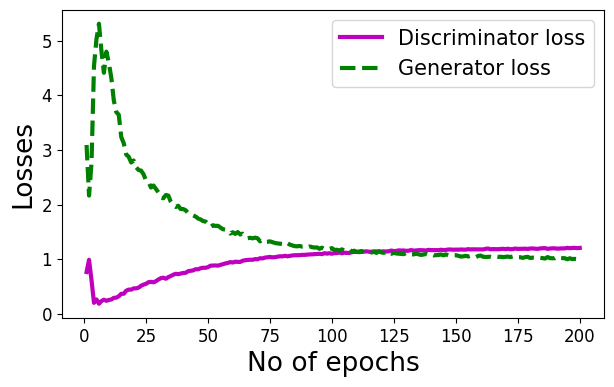

In [ ]:
N = np.arange(n_epochs) + 1
plt.figure(figsize=(7, 4))
plt.plot(N, discriminator_loss, 'm-', linewidth=3, label='Discriminator loss')
plt.plot(N, generator_loss, 'g--', linewidth=3, label='Generator loss')
plt.xlabel('No of epochs', fontsize=19)
plt.ylabel('Losses', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.show()

# Visualize the Discriminiator Loss and accuracy.

1. Discriminator starts with a higher accuracy because generator didnt produce very real images, but with each epoch generator began to learn better thus creating almost real images where the discriminator tend to get confused in identifying them as real and fake.
2. So discriminator loss increases and accuracy decreases, while we see the generator loss decreases.

3. Finally both discriminator and generator reach an equilibrium point where neither generator nor the discriminator is too strong.

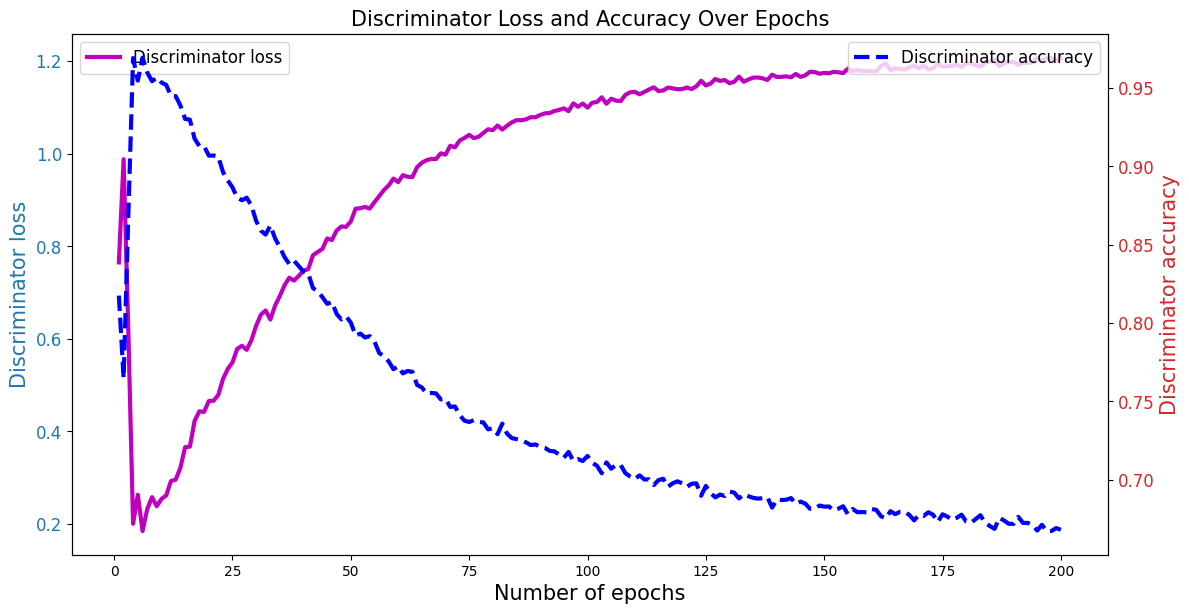

In [ ]:
# Plotting the discriminator loss and accuracy together
N = np.arange(n_epochs) + 1
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of epochs', fontsize=15)
ax1.set_ylabel('Discriminator loss', color=color, fontsize=15)
ax1.plot(N, discriminator_loss, 'm-', linewidth=3, label='Discriminator loss')
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.legend(loc='upper left', fontsize=12)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Discriminator accuracy', color=color, fontsize=15)
ax2.plot(N, discriminator_accuracy, 'b--', linewidth=3, label='Discriminator accuracy')
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.legend(loc='upper right', fontsize=12)

fig.tight_layout()
plt.title('Discriminator Loss and Accuracy Over Epochs', fontsize=15)
plt.show()

# Step 2 - Save Generator and Discriminator as G.pkl and D.pkl

In [ ]:
torch.save(generator.state_dict(), 'G.pkl')
torch.save(discriminator.state_dict(), 'D.pkl')

# Use the Generator G to create a dataset of 100 fake digits images (S1)

 **1. Shown below are the images generated by the model trained without any optimization for 100 epochs.**

Fake images created successfully


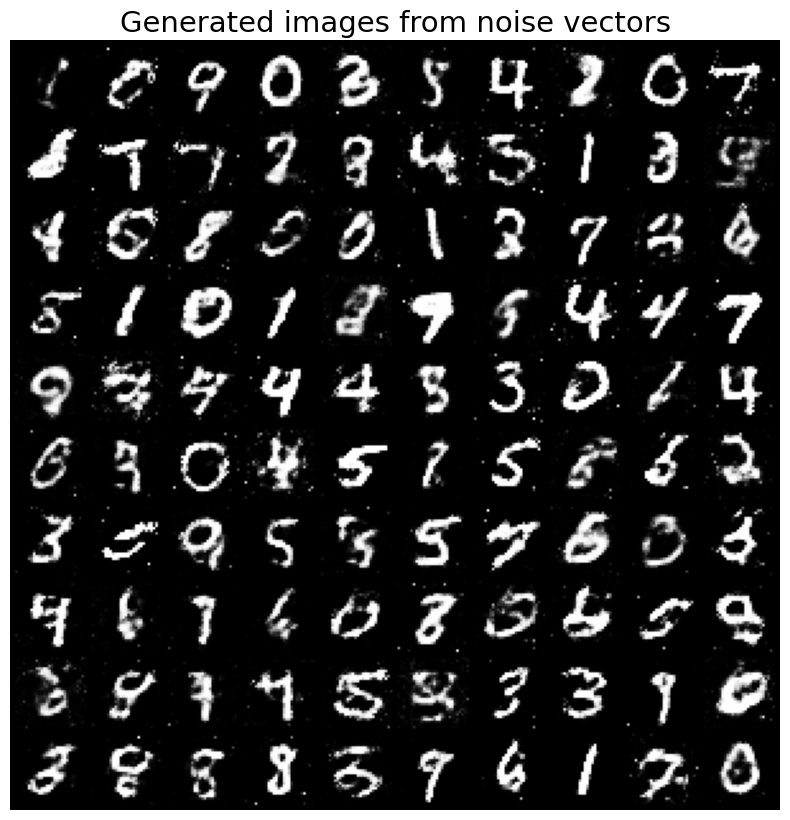

In [ ]:
import os
# Save the fake images and corresponding latent vectors
from torchvision.utils import save_image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the saved generator model
generator = GENERATOR().to(device)
generator.load_state_dict(torch.load('G.pkl', map_location=device))
generator.eval()  # Set to evaluation mode

# Generate 100 proper fake digit images -  I created a batch of 200 samples and chose the best 100 as instructed.
bs = 200  # Batch size
z_dim = 100  # Z dimensions
z = Variable(torch.randn(bs, z_dim).to(device))  # Latent input
fake_images = generator(z).cpu().detach()
fake_images = fake_images.view(bs, 1, 28, 28)

print("Fake images created successfully")


# Visualize some generated images in a 10 * 10 scale
grid = make_grid(fake_images[:100], nrow=10, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Generated images from noise vectors', fontsize=21)
plt.show()

**2. Shown below are the images generated after training the model for 200 epochs**

Fake images created successfully


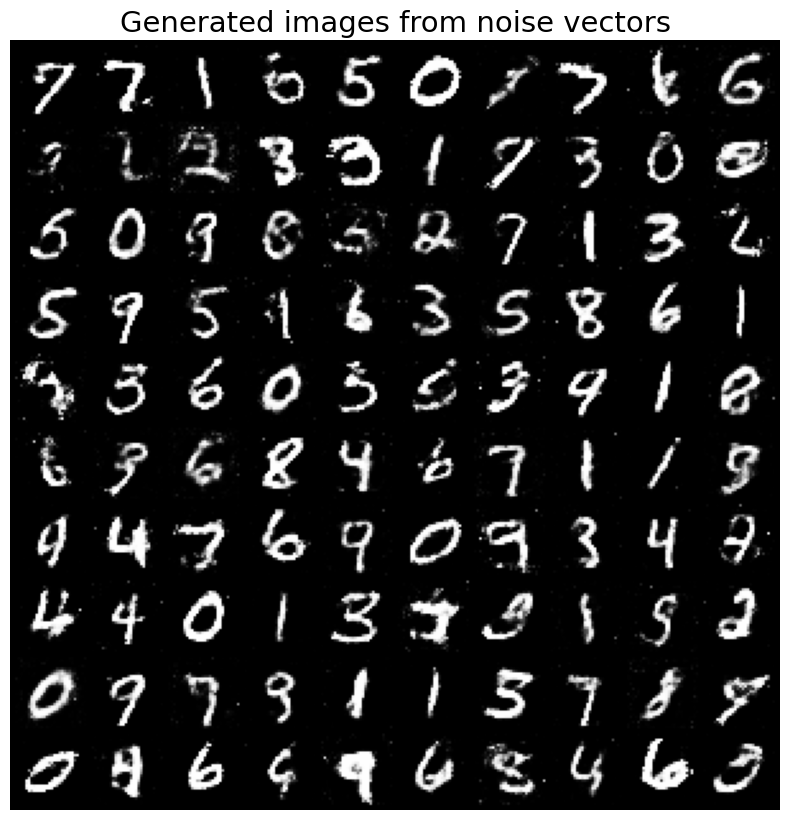

In [ ]:
import os
# Save the fake images and corresponding latent vectors
from torchvision.utils import save_image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the saved generator model
generator = GENERATOR().to(device)
generator.load_state_dict(torch.load('G.pkl', map_location=device))
generator.eval()  # Set to evaluation mode

# Generate 100 proper fake digit images -  I created a batch of 200 samples and chose the best 100 as instructed.
bs = 200  # Batch size
z_dim = 100  # Z dimensions
z = Variable(torch.randn(bs, z_dim).to(device))  # Latent input
fake_images = generator(z).cpu().detach()
fake_images = fake_images.view(bs, 1, 28, 28)

print("Fake images created successfully")


# Visualize some generated images in a 10 * 10 scale
grid = make_grid(fake_images[:100], nrow=10, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Generated images from noise vectors', fontsize=21)
plt.show()

**3. Shown below are the images generated after training the model for 200 epochs, optimizing the model further by changing the learning rates and dropout rates**

Fake images created successfully


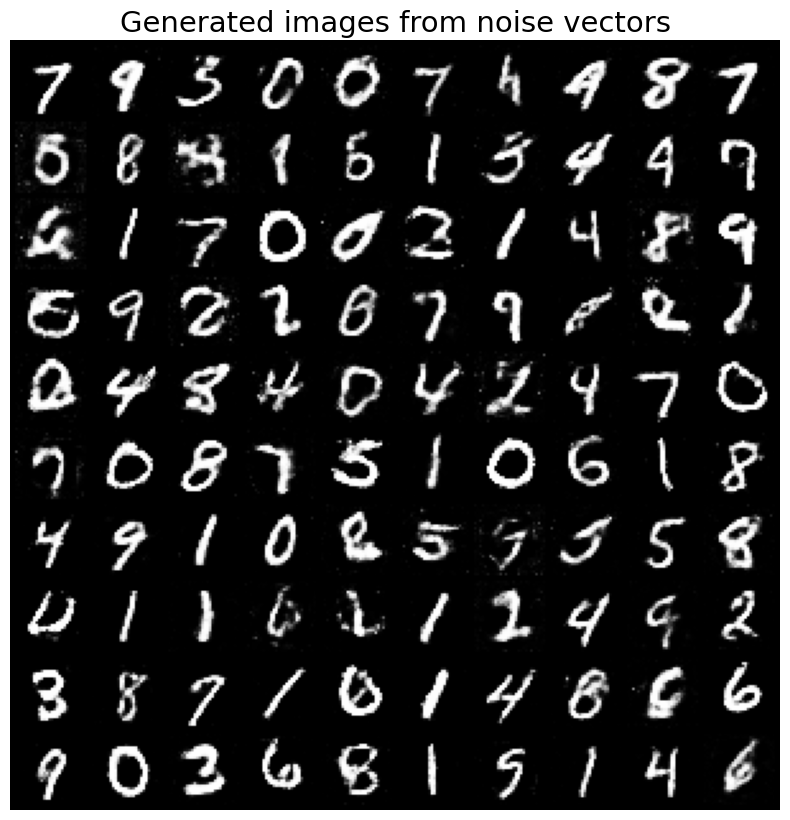

In [ ]:
#The correct one

import os
# Save the fake images and corresponding latent vectors
from torchvision.utils import save_image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the saved generator model
generator = GENERATOR().to(device)
generator.load_state_dict(torch.load('G.pkl', map_location=device))
generator.eval()  # Set to evaluation mode

# Generate 100 proper fake digit images -  I created a batch of 200 samples and chose the best 100 as instructed.
bs = 200  # Batch size
z_dim = 100  # Z dimensions
z = Variable(torch.randn(bs, z_dim).to(device))  # Latent input
fake_images = generator(z).cpu().detach()
fake_images = fake_images.view(bs, 1, 28, 28)

print("Fake images created successfully")


# Visualize some generated images on a 10 * 10 scale
grid = make_grid(fake_images[:100], nrow=10, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Generated images from noise vectors', fontsize=21)
plt.show()

Save all the fake images to a folder

In [ ]:
from torchvision.utils import save_image
from PIL import Image

# Create a folder to save the images and latent samples
os.makedirs('test', exist_ok=True)

for i in range(bs):
   # Save the image
    image_path = os.path.join('test', f'{i}.png')
    save_image(fake_images[i], image_path)

    # Convert the latent vector to a numpy array and save it with 16 digits after the decimal point
    latent_vector_path = os.path.join('test', f'{i}.txt')
    np.savetxt(latent_vector_path, z[i].cpu().detach().numpy(), fmt='%.16f')

print("Fake images and latent vectors saved successfully in the 'test' folder")


Fake images and latent vectors saved successfully in the 'test' folder


Download the folder as a zipped file.

In [ ]:
import shutil
from google.colab import files

# Create a zip file of the 'test' folder
shutil.make_archive('test', 'zip', 'test')

# Download the zip file
files.download('test.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 5 - Use the CNN Classifier

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=36,  #16
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(36, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

Instantiate CNN Model

In [ ]:
cnn=CNN()


Optimizer and Loss function

In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func

optimizer = optim.Adam(cnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

Train the CNN Classifier

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Evaluate accuracy

In [ ]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = Variable(images)
            labels = Variable(labels)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Access the logits if outputs is a tuple
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return 100 * correct / total

In [ ]:
torch.save(cnn.state_dict(), 'C-personal.pkl')

In [ ]:
num_epochs = 15

def train(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                train_accuracy = calculate_accuracy(loaders['train'], cnn)
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%'.format(
                    epoch + 1, num_epochs, i + 1, total_step, loss.item(), train_accuracy))

train(num_epochs, cnn, loaders)

Epoch [1/15], Step [100/468], Loss: 0.0088, Training Accuracy: 99.02%
Epoch [1/15], Step [200/468], Loss: 0.0185, Training Accuracy: 98.61%
Epoch [1/15], Step [300/468], Loss: 0.0291, Training Accuracy: 99.02%
Epoch [1/15], Step [400/468], Loss: 0.0078, Training Accuracy: 98.76%
Epoch [2/15], Step [100/468], Loss: 0.0759, Training Accuracy: 99.01%
Epoch [2/15], Step [200/468], Loss: 0.0045, Training Accuracy: 98.96%
Epoch [2/15], Step [300/468], Loss: 0.0016, Training Accuracy: 98.81%
Epoch [2/15], Step [400/468], Loss: 0.0137, Training Accuracy: 98.44%
Epoch [3/15], Step [100/468], Loss: 0.0339, Training Accuracy: 98.83%
Epoch [3/15], Step [200/468], Loss: 0.0762, Training Accuracy: 98.88%
Epoch [3/15], Step [300/468], Loss: 0.0403, Training Accuracy: 98.95%
Epoch [3/15], Step [400/468], Loss: 0.0512, Training Accuracy: 98.98%
Epoch [4/15], Step [100/468], Loss: 0.0334, Training Accuracy: 98.91%
Epoch [4/15], Step [200/468], Loss: 0.0418, Training Accuracy: 98.79%
Epoch [4/15], Step [

Save the Classifier trained pkl file

In [ ]:
torch.save(cnn.state_dict(), 'C.pkl')

Accuracy for the Testing dataset

In [ ]:
def test():
  cnn.eval()
  with torch.no_grad():
    correct=0
    total=0
    for images, labels in loaders['test']:
      test_output,last_layer=cnn(images)
      pred_y=torch.max(test_output,1)[1].data.squeeze()
      accuracy=(pred_y==labels).sum().item()/float(labels.size(0))
      accuracy = accuracy * 100
      pass
    print('Test Acc %.2f' % accuracy)
    pass


test()

Test Acc 99.22


In [ ]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:100].numpy()

In [ ]:
test_output,last_layer=cnn(imgs[:100])
pred_y=torch.max(test_output,1)[1].data.numpy().squeeze()

print(f'Prediction number {pred_y}')
print(f'Actual number {actual_number}')

Prediction number [2 3 8 2 6 7 8 2 7 5 7 1 4 1 7 6 9 7 9 1 4 5 2 0 1 3 8 4 8 3 8 5 2 4 7 1 8
 5 4 1 8 1 8 3 2 4 0 2 3 8 0 0 7 2 5 9 0 2 2 8 0 3 4 7 4 3 6 9 0 0 2 2 2 3
 2 0 9 3 8 5 1 2 2 0 4 5 5 6 2 1 6 7 0 2 9 4 1 6 0 9]
Actual number [2 3 8 2 6 7 8 2 7 5 7 1 4 1 3 6 9 7 9 1 4 5 2 0 1 3 8 4 8 3 8 5 2 4 7 1 8
 5 4 1 8 1 8 3 2 4 0 2 3 8 0 6 7 2 5 9 0 2 2 8 0 3 4 7 4 3 6 9 0 0 2 2 2 3
 2 0 9 3 8 5 1 2 2 0 4 5 5 6 2 1 6 7 0 2 9 4 1 6 0 9]


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm=confusion_matrix(actual_number, pred_y)

Confusion matrix, without normalization
[[11  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  1  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0]
 [ 1  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0  7]]


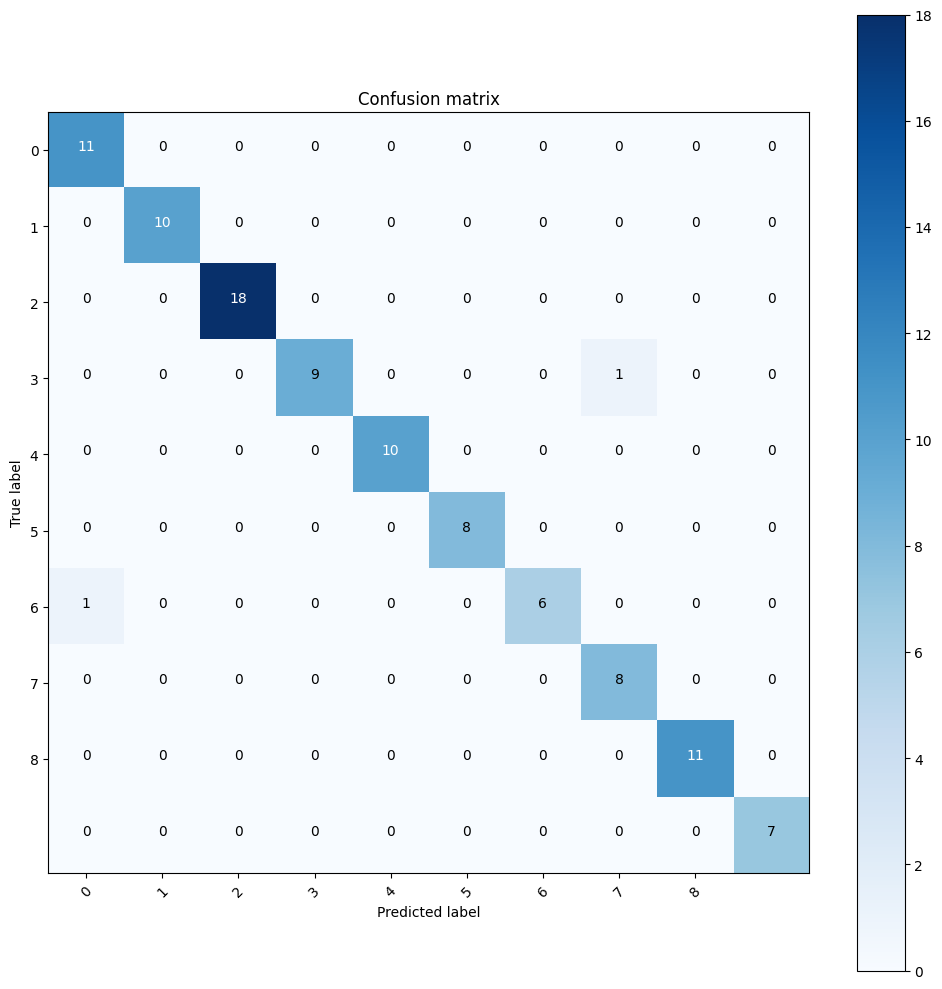

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, [str(i) for i in range(0,9)])

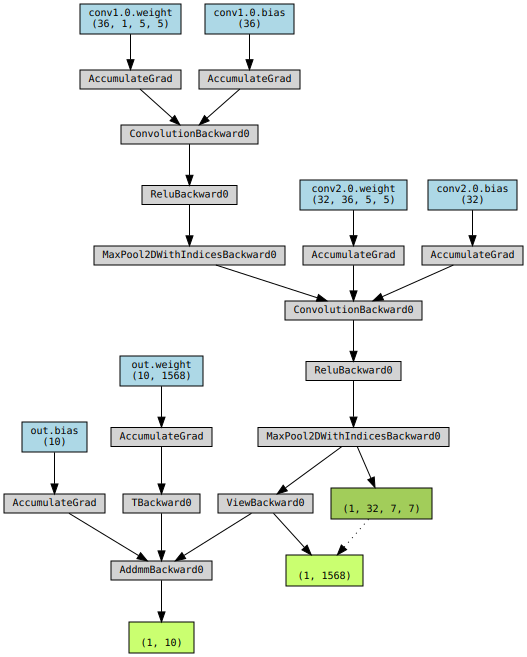

In [ ]:
make_dot (cnn(imgs[:1]), params=dict(cnn.named_parameters()))

Create a Random 100 images from Original dataset (S0)

In [ ]:
import random

# Set the random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Randomly select 100 samples from the test dataset
indices = random.sample(range(len(mnist_dataset_testing)), 100)
S0 = Subset(mnist_dataset_testing, indices)

# Create a DataLoader for S0
S0_loader = DataLoader(S0, batch_size=100, shuffle=False)

Calculate Classification error for S0

In [ ]:
def evaluate(cnn, data_loader):
  # Load the saved CNN model
    cnn = CNN().to(device)
    cnn.load_state_dict(torch.load('C.pkl', map_location=device))
    cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = Variable(images), Variable(labels)
            outputs, _ = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    classification_error = 1 - accuracy
    return accuracy, classification_error

In [ ]:
# Calculate classification error for S0
accuracy_S0, classification_error_S0 = evaluate(cnn, S0_loader)
print(f'Classification Accuracy for S0: {accuracy_S0:.2f}')
print(f'Classification Error for S0: {classification_error_S0:.2f}')


Classification Accuracy for S0: 0.99
Classification Error for S0: 0.01


Calculate Classification error for S1

Uploaded a zipped file of folders with class wise sub directories containing fake images generated

In [ ]:
# Specify the path to the zip file
zip_file_path = '/content/Fake_Digits.zip'

# Specify the directory to extract to
extract_to_dir = '/content'

os.makedirs(extract_to_dir, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents
    zip_ref.extractall(extract_to_dir)

print(f"Extracted all files to {extract_to_dir}")


Extracted all files to /content


In [ ]:
# Define a transform to convert images to grayscale and then to tensors
transform_S1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
])

In [ ]:
S1_dataset = torchvision.datasets.ImageFolder(root='/content/Fake_Digits', transform=transform_S1)

In [ ]:
S1_loader = DataLoader(S1_dataset, batch_size=100, shuffle=False)

Calculate the Classification error for S1

Shown below is the classification error obtained for 200 epochs training without any optimization.

In [ ]:
# Calculate classification error for S0
accuracy_S1, classification_error_S1 = evaluate(cnn, S1_loader)
print(f'Classification Accuracy for S1: {accuracy_S1:.2f}')
print(f'Classification Error for S1: {classification_error_S1:.2f}')

Classification Accuracy for S1: 0.77
Classification Error for S1: 0.23


Shown below is the classification error obtained for 200 epoch training after minor model optimizations.

In [ ]:
# Calculate classification error for S0
accuracy_S1, classification_error_S1 = evaluate(cnn, S1_loader)
print(f'Classification Accuracy for S1: {accuracy_S1:.2f}')
print(f'Classification Error for S1: {classification_error_S1:.2f}')

Classification Accuracy for S1: 0.79
Classification Error for S1: 0.21


# References

https://www.quora.com/Does-discriminator-real-example-accuracy-is-GAN-model-accuracy-If-not-how-to-calculate-GAN-model-accuracy


https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b

https://www.analyticsvidhya.com/blog/2021/10/an-end-to-end-introduction-to-generative-adversarial-networksgans/

https://kikaben.com/understanding-generative-adversarial-networks/

https://discuss.pytorch.org/t/runtimeerror-given-groups-1-weight-64-3-3-3-so-expected-input-16-64-256-256-to-have-3-channels-but-got-64-channels-instead/12765/13